In [1]:
from preprocess.preprocess import *
import PARAMETERS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from confusion_matrix_pretty_print import print_confusion_matrix
from pathlib import Path

%matplotlib inline

PARAMETERS.LBP_METHOD = 'riu'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False
PARAMETERS.DATASET = 'DRIVE'

pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

,LBP_METHOD,METHOD,INTERPOLATION_ALGORITHM,BALANCE,N_SCALES,GRAY_INTENSITY,X2SCALE
Parameters,riu,get_pyramid_dataset,lanczos,False,5,True,True


### Resultado CV

F1-score 0.685426

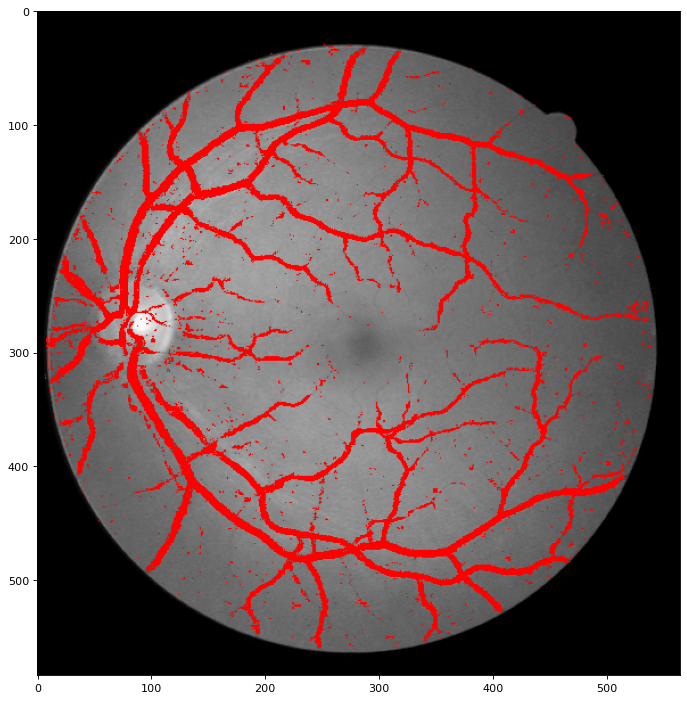

Accuracy score: 0.9292555186111174

F1 score: 0.7211952246541113

Confusion matrix:

     t/p      0     1 
        0 1141617 45928 
        1 50476 124686 
Sensivity: 0.7118324750802114
Specificity: 0.9613252550429668


(0.929, 0.721, 1141617, 45928, 50476, 124686)

In [2]:
from main import main
PARAMETERS.PLOT = True

main(lgb='Num', all_lbp=['riu', 'var'], plot_once=True, channels=(1, 2), recurrence=False)

In [3]:
import pickle
from os import listdir

PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/images'
MASK_PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/mask'
LABELS_PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/1st_manual'

def load_images():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][:14]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][:14]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES = load_images()
MASKS = load_masks()

In [4]:
with open(r'/home/fer/Drive/Estudios/Master-IA/TFM/lbp-pyramid/convolution/outputs/16496572770891893_3_5_7/population.pkl', 'rb') as f:
    kernels = pickle.load(f)
    
population, fitness = kernels['population'], kernels['fitness']
individual = population[np.argmax(fitness), :]
n_kernels = 6
k_size = (3, 5, 7)

features = [pd.DataFrame()]*14
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES, MASKS, features)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features = pd.concat(features, ignore_index=True)
display(conv_features)

,0,1,2,3,4,5
0,34,4,0,20,126,140
1,38,4,0,19,119,138
2,43,7,0,18,111,136
3,51,7,0,15,109,134
4,51,4,0,16,106,137
...,...,...,...,...,...,...
3178294,10,0,28,81,110,0
3178295,9,1,26,82,109,0
3178296,12,1,25,80,115,0
3178297,9,0,25,79,113,0


In [5]:
import pandas as pd
import numpy as np

preprocess = Preprocess(height=608, width=576)
masks_path = f'../dataset/{PARAMETERS.DATASET}/training/mask/'
masks = sorted(os.listdir(masks_path))[:14]

n_pixels = {}
for i, mask_path in enumerate(masks):
    mask = preprocess.read_img(masks_path + mask_path)
    n_pixels[i] = np.sum(mask > 100)
    
pixel_ref = {}

for k, v in n_pixels.items():
    upper = np.sum(np.array(list(n_pixels.values()))[:k+1])
    pixel_ref[k] = (upper - n_pixels[k], upper)

cv_folds = {}

for i, j in enumerate(range(0, 14, 3)):
    cv_folds[i] = (pixel_ref[j][0], pixel_ref[min(j+2, 13)][1])
    
cv_folds

{0: (0, 681473),
 1: (681473, 1361653),
 2: (1361653, 2044115),
 3: (2044115, 2724019),
 4: (2724019, 3178299)}

In [6]:
from main import init_clf_and_fit
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def test_features(features, verbose=False):
    f1_list = []
    acc_list = []
    if isinstance(features['y_train'], pd.Series):
        features['y_train'] = features['y_train'].to_frame()
    for k, v in cv_folds.items():
        PARAMETERS.MODEL_NAME = f"_cv_feat_sel_{k}"
        df_train_temp = pd.concat(
            [features['x_train'].iloc[cv_folds[0][0]:v[0], :],
             features['x_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        y_train_temp = pd.concat(
            [features['y_train'].iloc[cv_folds[0][0]:v[0], :],
             features['y_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        clf = init_clf_and_fit(
            df_train_temp, y_train_temp.values.ravel(), lgb='Num', parent_path='../models')
        y_predicted = clf.predict(features['x_train'].iloc[v[0]:v[1], :])
        acc = accuracy_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        acc_list.append(acc)
        f1 = f1_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        f1_list.append(f1)
        mat = confusion_matrix(features['y_train'].iloc[v[0]:v[1], :], y_predicted).ravel()
        if verbose:
            print('Accuracy score: ' + str(acc) + '\n')
            print('F1 score: ' + str(f1) + '\n')
            print('Confusion matrix:\n')
            print_confusion_matrix(features['y_train'].iloc[v[0]:v[1], :].values.ravel(), y_predicted.ravel())
            print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
            print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')
            print('-------------------------------------')

    return {'acc': np.mean(acc_list), 'f1': np.mean(f1_list)}

In [19]:
from main import get_channel_features, get_labels
import pandas as pd

df_train, df_test = get_channel_features('../', lbp_version=['riu', 'var'], channels=(1, 2))
conv_features.index = df_train.index
y_train, y_test = get_labels('../')

In [20]:
display(df_train)

df_train = pd.concat([df_train, conv_features], axis=1)

features = {'x_train': df_train, 'x_test': None, 'y_train': y_train, 'y_test': None}

,green_Original,green_riu_1:1,green_riu_1:2,green_riu_1:4,green_riu_1:8,green_riu_2:1_1,green_riu_2:1_2,green_riu_2:1_3,green_riu_2:1_4,blue_Original,...,green_var_2:1_3,green_var_2:1_4,blue_var_1:1,blue_var_1:2,blue_var_1:4,blue_var_1:8,blue_var_2:1_1,blue_var_2:1_2,blue_var_2:1_3,blue_var_2:1_4
0,0.0,35.0,8.0,8.0,8.0,35.0,35.0,8.0,8.0,1.0,...,55.0,69.0,27.176735,1637.007165,1306.551069,1157.878241,10.0,13.0,3.0,1.0
1,0.0,27.0,8.0,8.0,8.0,35.0,27.0,8.0,8.0,1.0,...,86.0,102.0,46.207535,1637.007165,1306.551069,1157.878241,13.0,14.0,3.0,9.0
2,0.0,8.0,8.0,8.0,8.0,35.0,27.0,16.0,8.0,0.0,...,138.0,154.0,70.187899,1788.711292,1320.562749,1157.878241,11.0,9.0,7.0,6.0
3,0.0,4.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,...,166.0,180.0,72.674270,1788.711292,1320.562749,1157.878241,6.0,3.0,11.0,27.0
4,0.0,8.0,8.0,8.0,8.0,8.0,8.0,4.0,8.0,0.0,...,196.0,214.0,62.853232,1848.534023,1320.562749,1157.878241,2.0,2.0,37.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226537,0.0,16.0,4.0,27.0,8.0,8.0,8.0,8.0,8.0,0.0,...,84.0,75.0,19.041829,295.481488,507.872500,985.396140,0.0,1.0,0.0,0.0
226538,0.0,8.0,4.0,27.0,8.0,16.0,8.0,35.0,35.0,0.0,...,69.0,66.0,18.681217,295.481488,507.872500,985.396140,1.0,2.0,0.0,0.0
226539,0.0,8.0,8.0,16.0,8.0,8.0,8.0,8.0,16.0,0.0,...,61.0,51.0,13.971574,228.299942,469.304608,985.396140,0.0,0.0,0.0,0.0
226540,0.0,16.0,8.0,16.0,8.0,8.0,8.0,16.0,8.0,0.0,...,41.0,28.0,9.588321,228.299942,469.304608,985.396140,0.0,0.0,0.0,0.0


In [17]:
test_features(features, verbose=True)

Accuracy score: 0.9386784215955731

F1 score: 0.7215978361525086

Confusion matrix:

     t/p      0     1 
        0 585527 19782 
        1 22007 54157 
Sensivity: 0.711057717556851
Specificity: 0.9673191708697542
-------------------------------------
Accuracy score: 0.9242626951689259

F1 score: 0.6798779540525592

Confusion matrix:

     t/p      0     1 
        0 573961  8844 
        1 42671 54704 
Sensivity: 0.5617869062901155
Specificity: 0.9848251130309452
-------------------------------------
Accuracy score: 0.9381225621353276

F1 score: 0.7491162718852667

Confusion matrix:

     t/p      0     1 
        0 577187 16257 
        1 25972 63046 
Sensivity: 0.7082387831674493
Specificity: 0.9726056713017572
-------------------------------------
Accuracy score: 0.9410916835317927

F1 score: 0.7008544455066921

Confusion matrix:

     t/p      0     1 
        0 592934 14240 
        1 25812 46918 
Sensivity: 0.6450983088134195
Specificity: 0.9765470853495044
-------------------

{'acc': 0.9293987576144387, 'f1': 0.7004519806360594}

,0,1,2,3,4,5
0,9,1,0,17,82,62
1,9,1,0,16,81,59
2,9,0,0,17,81,62
3,8,0,0,17,84,66
4,8,2,0,14,87,67
...,...,...,...,...,...,...
1362702,8,1,14,44,73,5
1362703,8,2,13,44,72,0
1362704,8,1,12,44,71,0
1362705,8,0,13,45,71,0


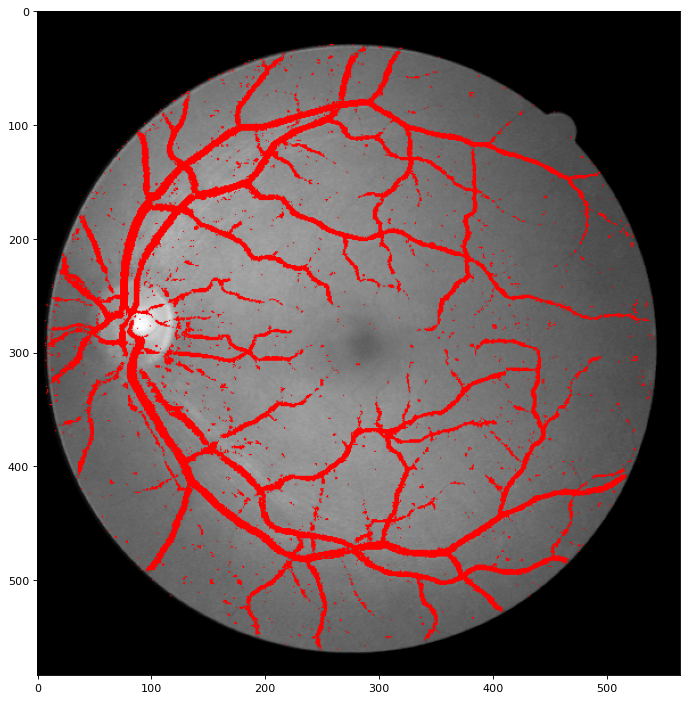

Accuracy score: 0.9318855777507564

F1 score: 0.7343187373699788

Confusion matrix:

     t/p      0     1 
        0 1141614 45931 
        1 46889 128273 
Sensivity: 0.7323106609881138
Specificity: 0.9613227288229078


(0.932, 0.734, 1141614, 45931, 46889, 128273)

In [29]:
def load_images_test():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][14:]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks_test():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][14:]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES_test = load_images_test()
MASKS_test = load_masks_test()

features_test = [pd.DataFrame()]*14
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features_test = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES_test, MASKS_test, features_test)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features_test = pd.concat(features_test, ignore_index=True)
conv_features_test.index = df_test.index
display(conv_features_test)

extra_features = {'train': conv_features, 'test': conv_features_test}
main(lgb='Num', all_lbp=['riu', 'var'], extra_features=extra_features, plot_once=True, channels=(1, 2), recurrence=False)

### Clasificador utilizando únicamente la intensidad de gris en el canal verde

In [34]:
green_channel_train = pd.DataFrame(
    [item for sublist in [img[mask].ravel().tolist() for img, mask in zip(IMAGES, MASKS)] for item in sublist]
)
green_channel_train.index = y_train.index
green_channel_test = pd.DataFrame(
    [item for sublist in [img[mask].ravel().tolist() for img, mask in zip(IMAGES_test, MASKS_test)] for item in sublist]
)
green_channel_test.index = y_test.index

In [35]:
display(green_channel_train)

,0
0,4
1,3
2,3
3,10
4,9
...,...
226537,6
226538,3
226539,9
226540,4


In [36]:
features = {
    'x_train': green_channel_train, 'x_test': green_channel_test,
    'y_train': y_train, 'y_test': y_test
}

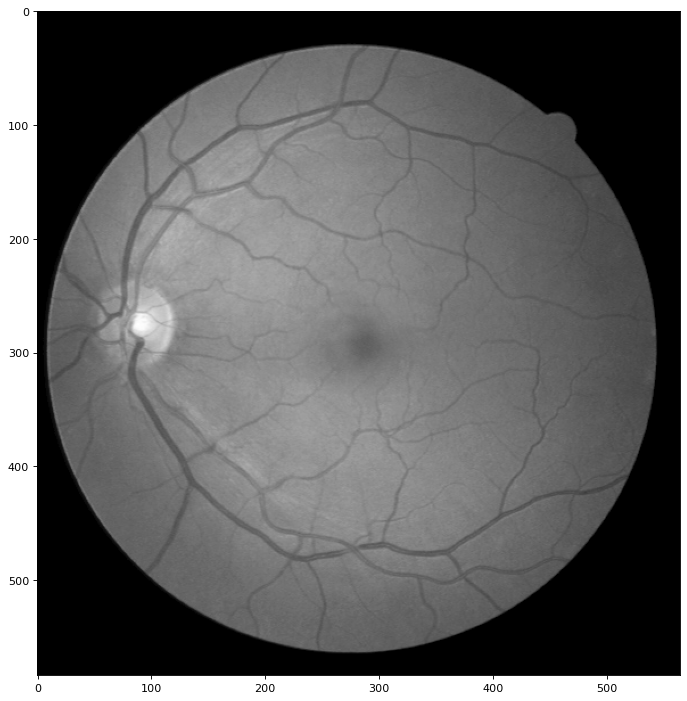

Accuracy score: 0.8714602625509372

F1 score: 0.0

Confusion matrix:

     t/p      0     1 
        0 1187545     0 
        1 175162     0 
Sensivity: 0.0
Specificity: 1.0


(0.871, 0.0, 1187545, 0, 175162, 0)

In [37]:
main(lgb='Num', features=features, plot_once=True, recurrence=False)

### Resultados convolución

Green channel


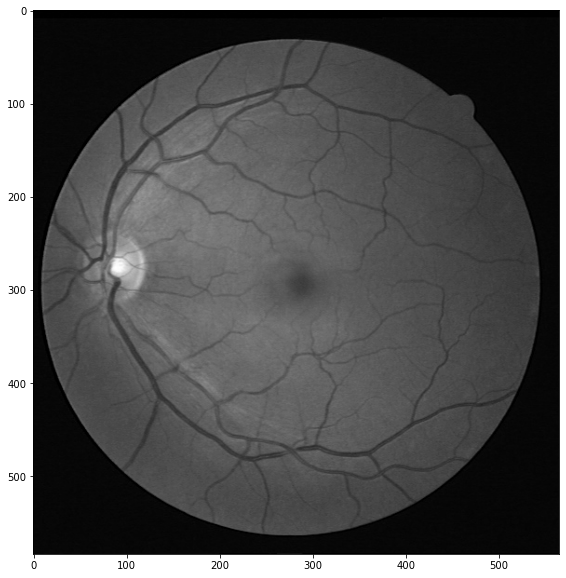


 Convolved images


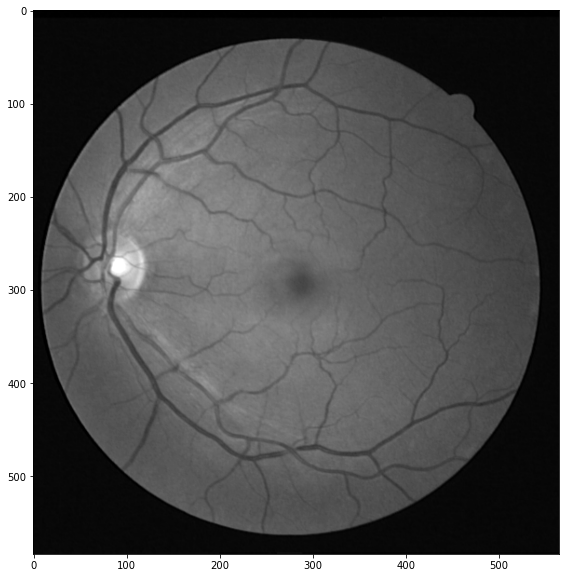

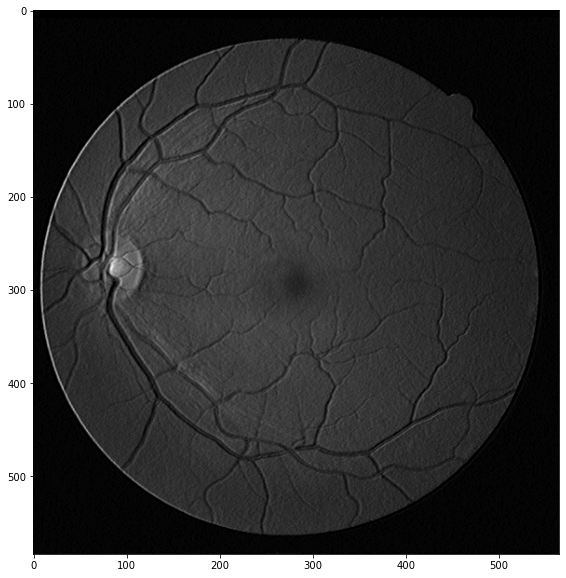

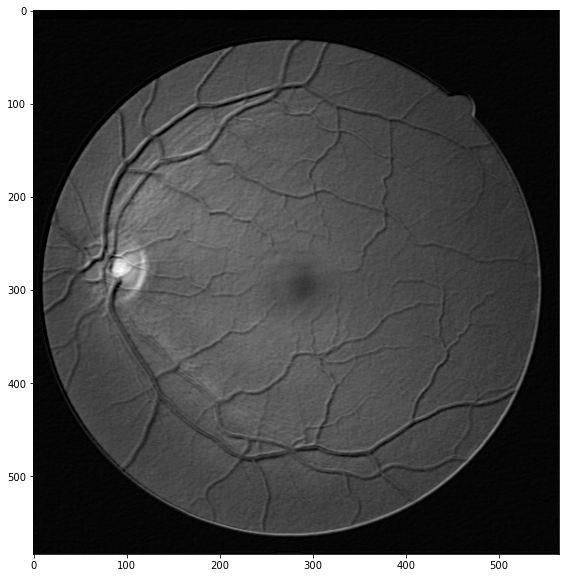

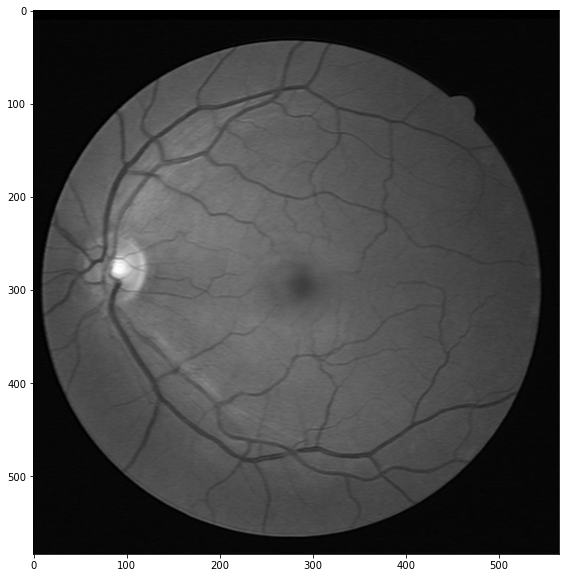

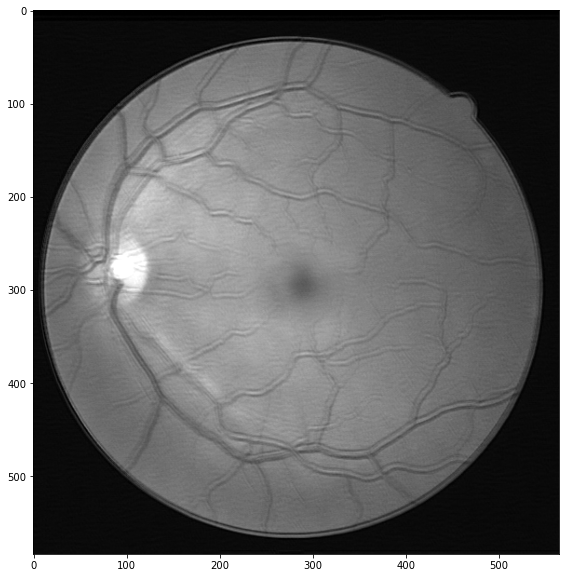

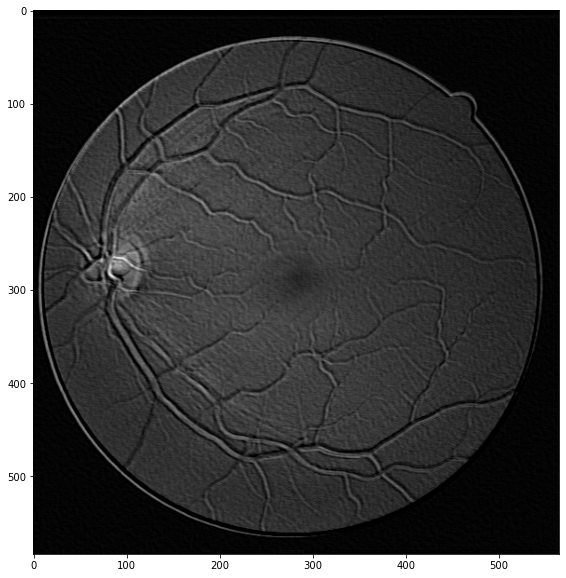

In [39]:
import numpy as np
import pickle


kernel_list = [population[np.argmax(fitness), k:k+9] for k in range(0, len(individual), 9)]

kernel_list = []
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    kernel_list += [
        individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks))
        for i in range(n_kernels // len(k_size))
    ]
    count += k_len * (n_kernels // len(k_size))


PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/images'
path = PATH + '/35_training.tif'

from os import listdir
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from preprocess.preprocess import Preprocess

img = np.asarray(Image.open(path).convert('RGB'))[:, :, 1]
img_convolved = [cv2.filter2D(img, -1, k) for k in kernel_list]
import matplotlib.pyplot as plt
from PIL import Image
from convolution.fitness import IMAGES

im_list = [Image.fromarray(np.uint8(im)) for im in img_convolved]

print('Green channel')
plt.figure(figsize=(18, 10))
plt.imshow(img, cmap='gray')
plt.show()

print('\n Convolved images')
for im in im_list:
    plt.figure(figsize=(18, 10))
    plt.imshow(im, cmap='gray')
    plt.show()

In [40]:
features = {'x_train': extra_features['train'], 'x_test': extra_features['test'], 'y_train': y_train, 'y_test': y_test}

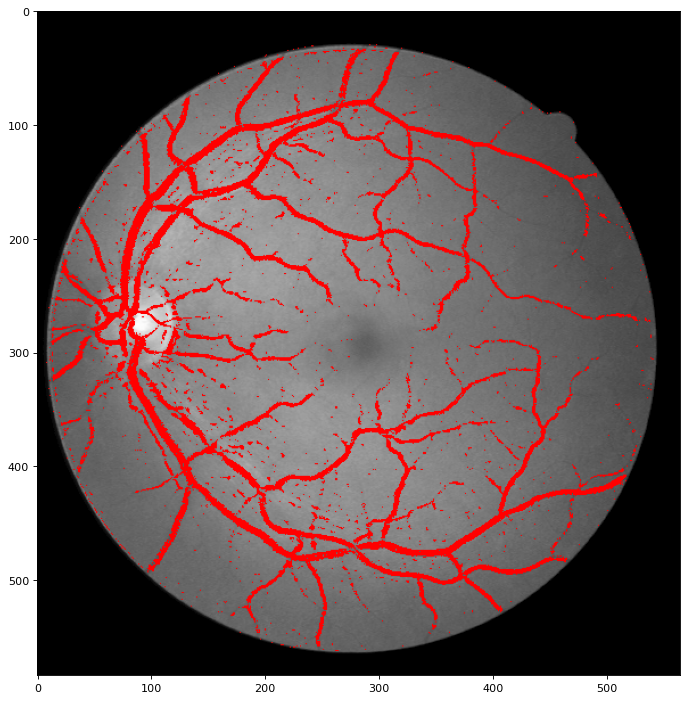

Accuracy score: 0.9295923481716906

F1 score: 0.694020735600366

Confusion matrix:

     t/p      0     1 
        0 1157951 29594 
        1 66351 108811 
Sensivity: 0.6212020872106964
Specificity: 0.9750796811910285


(0.93, 0.694, 1157951, 29594, 66351, 108811)

In [41]:
main(lgb='Num', features=features, plot_once=True, recurrence=False)

## Combinación de resultados

In [46]:
green_channel_train.columns = ['green']
green_channel_test.columns = ['green']
features = {
    'x_train': pd.concat([extra_features['train'], green_channel_train], axis=1),
    'x_test': pd.concat([extra_features['test'], green_channel_test], axis=1),
    'y_train': y_train,
    'y_test': y_test
}

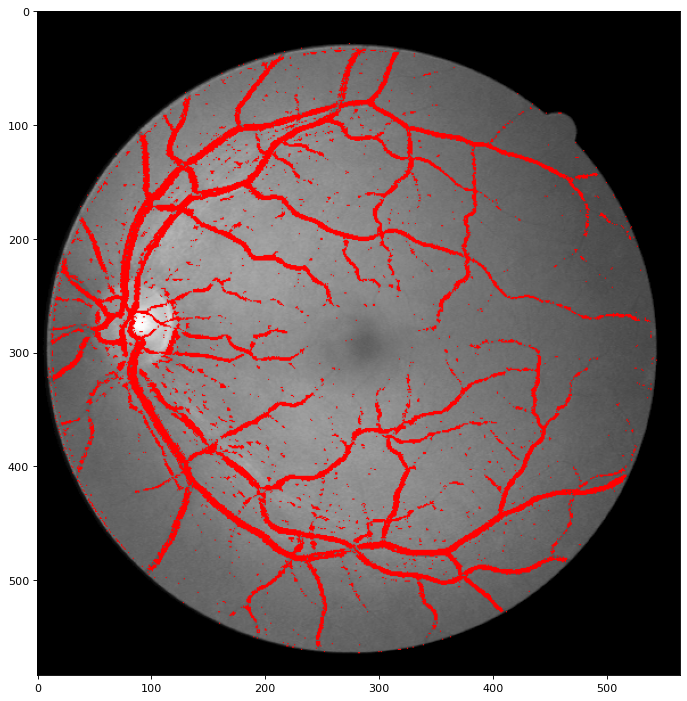

Accuracy score: 0.9291124210853837

F1 score: 0.6926408028330794

Confusion matrix:

     t/p      0     1 
        0 1157264 30281 
        1 66318 108844 
Sensivity: 0.6213904842374488
Specificity: 0.9745011767975108


(0.929, 0.693, 1157264, 30281, 66318, 108844)

In [47]:
main(lgb='Num', features=features, plot_once=True, recurrence=False)

## Ejecución con 6 núcleos y lightGBM

#### PARAMETERS

Population size: 80

k (tournament selection): 2

alpha (recombination): 0.6

sigma (mutation): 0.4

Mutation probability: 0.1
Recombination probability: 0.6

#### BEST RESULT

Fitness: 0.6404590596364136

Kernels: 
[-0.01896793  0.16685353 -0.04073357  0.03758321  0.45592933 -0.04249785
 -0.00813372  0.3915514   0.19219148  0.03675487 -0.07839416  0.05116644
 -0.21755329  0.05680535  0.20516737 -0.04514586  0.01780444  0.07979146
  0.01379418  0.06380112 -0.00979854 -0.06510548  0.14660235  0.0230366
  0.06971492  0.12629304  0.01615944  0.00659898  0.10571844  0.08066367
  0.14782103  0.02178885  0.12769831 -0.03491611  0.10530013  0.01098105
 -0.01274467 -0.00326741  0.14321016  0.04362726  0.03971864 -0.3119849
 -0.36954096  0.15610715  0.05976684  0.23836276  0.11750713 -0.0482398
  0.06599869  0.1778247   0.30698926 -0.01511237  0.07534552  0.06109792
  0.10522571 -0.2492347   0.06034471 -0.00848499 -0.18687127 -0.02362721
 -0.12048924  0.01385463  0.03609491  0.24271949 -0.0806105   0.06153911
 -0.0107063  -0.04703809  0.46960823  0.16288285 -0.05486061  0.2454989
  0.01421689  0.1126543  -0.04798373  0.17454166  0.10024941 -0.12656502
  0.00181107 -0.01693136  0.03298144  0.11627212  0.07960637 -0.10203323
  0.11074288  0.06768355  0.03535985  0.01544107  0.08108118 -0.05501648
  0.02114117 -0.05966445 -0.05202833 -0.20416821 -0.33658119  0.11517139
  0.18499377 -0.54335435  0.08543699 -0.04258854  0.06531281 -0.25807591
  0.18750533  0.03718695  0.0297607  -0.06573044  0.09287543 -0.00086815
 -0.0620434  -0.00877052  0.12896096  0.17194058  0.02684301 -0.06728001
  0.61282197  0.00965481 -0.03104777 -0.21216407 -0.04838598  0.08602382
  0.11233927  0.12737903 -0.07954881  0.00346604  0.10193438  0.0709723
 -0.30516896  0.02415857  0.0097318   0.17443726  0.49972783 -0.20897906
 -0.5545098   0.06199937 -0.50610131 -0.08374255 -0.05476889  0.1658088
  0.51391149 -0.02487457 -0.34191152 -0.37124034 -0.10180524  0.01478267
  0.11479996 -0.06664025  0.36000988  0.16913314 -0.08847245 -0.0164314
  0.09117855  0.06823051 -0.07336272  0.06465331 -0.06436073  0.1401178
  0.0681433   0.02841955 -0.11472597  0.41836398  0.37828967  0.1046755
 -0.29145534  0.00834706  0.08921102  0.02397168]